<a href="https://colab.research.google.com/github/tahamsi/computer-vision/blob/main/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code serves two vital purposes: face detection and face recognition. To achieve these objectives, it utilizes two pretrained deep neural networks.

Multi-task Cascaded Convolutional Networks (MTCNN) is a deep learning model that excels in face alignment and detection. At each stage of the process, convolutional networks are employed to identify faces and facial landmarks such as the nose, eyes, and mouth (Gradilla, 2020). The MTCNN operates in three stages. Firstly, an image pyramid is created by resizing the image to different scales, serving as the input for the subsequent three-staged cascaded network (Gradilla, 2020).

VGGFACE, which generates embedding features. The similarity between two faces is determined by comparing the embeddings using vector comparison metrics such as cosine similarity, dot product, or Euclidean distance.
Experimental results demonstrate that comparing embeddings significantly outperforms comparing the original features, leading to more accurate and reliable face recognition results.

In [ ]:
! pip install keras_vggface
! pip install keras_applications --no-deps
! pip install mtcnn
! pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.4 MB/s eta 0:00:00


In [ ]:
filename = "/usr/local/lib/python3.10/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

20951

In [ ]:
import tensorflow as tf
from keras_vggface.vggface import VGGFace
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from scipy.spatial.distance import cosine
from keras_vggface.utils import preprocess_input
from skimage import color
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
class Face:
  def __init__(self, model_type, pooling_type):
    self.detector = MTCNN()
    self.model = VGGFace(model = model_type, include_top=False, input_shape=(224, 224, 3), pooling = pooling_type)

  def draw_facebox(self, filename): # this method draws a box around detected faces
    pixels = np.asarray(filename)
    pyplot.imshow(pixels)
    results = self.detector.detect_faces(pixels)
    ax = pyplot.gca()
    for result in results:
        x, y, width, height = result['box']
        rect = pyplot.Rectangle((x, y), width, height, fill=False, color='orange')
        ax.add_patch(rect)
        #ax.add_patch(self.cover_facebox(result))
    pyplot.show()

  def cover_facebox(self, result): # this method finds keypoints and covers them with a circle
    ax = pyplot.gca()
    for key, value in result['keypoints'].items():
      # create and draw dot
      dot = pyplot.Circle(value, radius=10, color='red')
      ax.add_patch(dot)
    return ax


  def extract_face(self, filename, required_size=(224, 224)):
  # you need to specify the size, it is 224 by 224 by default.
  # This function accepts a filename (you can change it with an opened file),
  # a detector which is an already trained neural network and returns a list of embedings
  # the size of the list shows the number of detected faces.
    pixels = np.asarray(filename)#pyplot.imread(filename)
    results = self.detector.detect_faces(pixels)
    if len(results)==0:
        return 0
    res = []
    for result in results:
        x1, y1, width, height = result['box']
        x2, y2 = x1 + width, y1 + height
        face = pixels[y1:y2, x1:x2]
        image = Image.fromarray(face.copy())
        image = image.resize(required_size)
        face_array = asarray(image)
        res.append(face_array)
    return res

  def look_for_faces(self, file_name, show=True):
    # this would be one api for face detection. However, we should wrap them
    # in a class.
    pixels = self.extract_face(file_name)
    if pixels ==0:
      print("No face has been detected!")
    else:
      if show:
        for pixel in pixels:
          pyplot.imshow(pixel)
          pyplot.show()
      else:
        print(len(pixels), "faces have been detected!")

    # extract faces and calculate face embeddings for a list of photo files
  def get_embeddings(self,filenames):
    faces = self.extract_face(filenames)
    if len(faces)==0:
      return 0
    samples = asarray(faces, 'float32')
    samples = preprocess_input(samples, version=2) # version = 1: VGGFace1
    yhat = self.model.predict(samples)
    return yhat

  # determine if a candidate face is a match for a known face
  def is_match(self,known_embedding, candidate_embedding, thresh=0.5):
    # calculate distance between embeddings
    score = cosine(known_embedding, candidate_embedding)
    if score <= thresh:
      print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
    else:
      print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))

In [ ]:
#’vgg16′ (the default), and two VGGFace2 models ‘resnet50‘ and ‘senet50‘.
face = Face("resnet50", "max")

94694792/94694792 [==============================] - 1s 0us/step


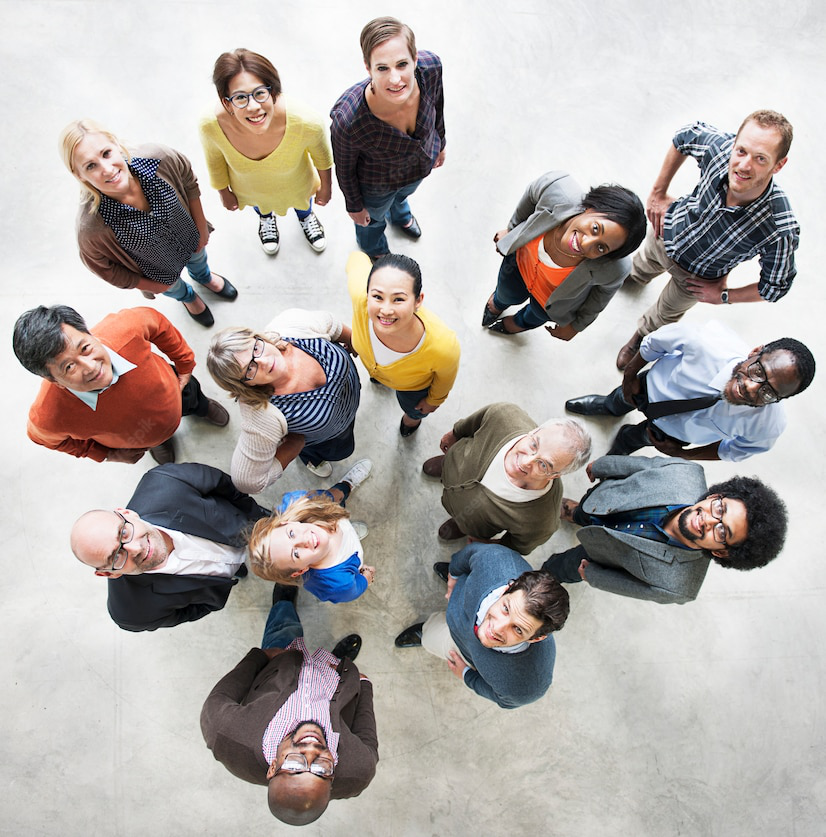

In [ ]:
from urllib.request import urlopen
from PIL import Image
url = "https://img.freepik.com/premium-photo/blurred-vision-diverse-people_53876-10652.jpg?w=826"
img = Image.open(urlopen(url))
img

4/4 [==============================] - 0s 37ms/step


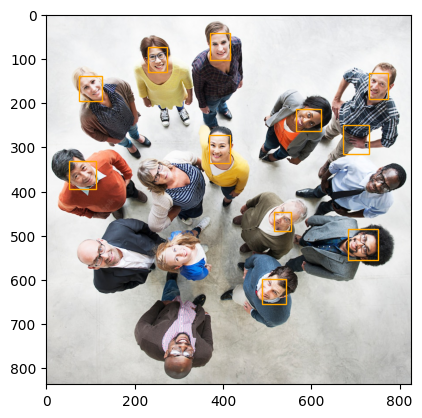

In [ ]:
#face.look_for_faces(img)
face.draw_facebox(img)

In [ ]:
# you need to extract two set of embedings from two images
embeddings_1 = face.get_embeddings(img)
#embeddings_2 = face.get_embeddings('Second.jpg')

1/1 [==============================] - 2s 2s/step


In [ ]:
# now you can compare them together.
for embd in embeddings_1:
  face.is_match(embd, embeddings_1[0],0.4)

>face is a Match (0.000 <= 0.400)
>face is NOT a Match (0.756 > 0.400)
>face is NOT a Match (0.733 > 0.400)
>face is NOT a Match (0.715 > 0.400)
>face is NOT a Match (0.618 > 0.400)
>face is NOT a Match (0.776 > 0.400)
>face is NOT a Match (0.746 > 0.400)
>face is NOT a Match (0.727 > 0.400)
>face is NOT a Match (0.887 > 0.400)
>face is NOT a Match (0.706 > 0.400)
>face is NOT a Match (0.871 > 0.400)
